In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sphfile import SPHFile   # to read timit sphere files
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
import fric_meas            # fric_meas.py

from audiolabel import read_label   # Ronald Sprouse's audiolabel library - to read TextGrid files
from phonlab.utils import dir2df    # Ronald Sprouse's dir2df - to make a dataframe from a directory

In [40]:
timit = Path('/Volumes/KJohnson/Corpora/TIMIT')

# get a dataframe listing all of the phone label files in the database
tgdf = dir2df(timit, fnpat='\.phn$', addcols=['barename'])
print(f'Found {len(tgdf)} .phn files.')


tgdf

Found 6279 .phn files.


,relpath,fname,barename
0,test/dr1/faks0,sa1.phn,sa1
1,test/dr1/faks0,sa2.phn,sa2
2,test/dr1/faks0,si1573.phn,si1573
3,test/dr1/faks0,si2203.phn,si2203
4,test/dr1/faks0,si943.phn,si943
...,...,...,...
6274,train/dr8/mtcs0,sx172.phn,sx172
6275,train/dr8/mtcs0,sx262.phn,sx262
6276,train/dr8/mtcs0,sx352.phn,sx352
6277,train/dr8/mtcs0,sx442.phn,sx442


In [41]:
from importlib import reload 
reload(fric_meas)

phone_set = ['f','v','th','dh','s','z','sh', 'zh', 'hh', 'hv']  # all work below will be limited to these labels in the phn files

phones_data = pd.DataFrame(columns=("speaker","sentence","dr","gender","phone","time",
                                    "dur","Fm","FmB","Am","Ll","Lm","Lh","mode","COG",
                                    "SD","Skew","Kurtosis"))
relpath = ""
preemph = 0.96

for row in tgdf.itertuples():   # loop through all of the phn label filwe
    if row.relpath != relpath:  # a progress indicator
        relpath=row.relpath
        items = relpath.split("/")  # split on '/'  - 
        base = 1  # how deep is the directory structure
        dr = items[base]        #    dr = dialect region
        gend = items[base+1][0]   #    gend = first letter of the third item 
        speaker = items[base+1]
        print(f"\r {relpath}: Dialect region {dr}, Gender {gend}", end = '') # print a progress message
    
    # ---------- open the sound file ----------------------------------------------------
    wavname = timit / row.relpath / f'{row.barename}.wav'  # construct the name of the wav file
    try:
        sph = SPHFile(wavname)          # TIMIT files are NIST SPHERE format!
        sf = sph.format['sample_rate']
        x = sph.content
        x = x.astype(np.float32, order='C') / 32768.0  # convert to -1.0, 1.0 floating point range
    except:
        print(f'missing wav file: {wavname}')
        continue
        
    x2 = np.append(x[0], x[1:] - preemph * x[:-1])  # apply pre-emphasis

    # ---------- open the phone label file, and select target sounds ---------------------------
    filename = timit / row.relpath / row.fname
    sentence = row.barename
    
    # TIMIT phn files have three columns, t1 and t2 are in samples
    phdf = pd.read_csv(filename, sep=" ", header=None, names=["t1", "t2", "label"])
    
    phdf = phdf.loc[phdf['label'].isin(phone_set)]     # limit to the target phones
    phdf['dur'] = (phdf.t2 - phdf.t1)/sf   # calculate the duration
    phdf = phdf[phdf.dur>0.04]  # don't analyze anything under 40ms long
    phdf['midpt'] = phdf.loc[:, ['t1', 't2']].mean(axis='columns')  # add midpoint time values
    
    # ---------- measure some fricative properties ---------------------------------------------
    for phone,mid,dur in zip(phdf['label'],phdf['midpt'],phdf['dur']):  # get fricative measures
        (Fm,FmB,Am,Ll,Lm,Lh,mode,COG,SD,Skew,Kurtosis,spec,freq) = fric_meas.main_peak(x2,mid/sf,sf)

        # add a row to the data frame
        phones_data.loc[len(phones_data.index)] = [speaker,sentence,dr,gend,phone,mid,dur,Fm,FmB,Am,Ll,Lm,Lh,mode,COG,SD,Skew,Kurtosis] 

        if phone=='s':   # keep some examples for later
            s_spec = spec
            s_Fm = Fm
            s_COG = COG
        if phone=='z': 
            z_spec = spec
            z_Fm = Fm
            z_COG = COG
        if phone=='sh':
            sh_spec = spec
            sh_Fm = Fm
            sh_COG = COG
        if phone=='zh':
            zh_spec = spec
            zh_Fm = Fm
            zh_COG = COG
        if phone=='v':
            v_spec = spec
            v_Fm = Fm
            v_COG = COG
        if phone=='f':
            f_spec = spec
            f_Fm = Fm
            f_COG = COG
        if phone=='th':
            th_spec = spec
            th_Fm = Fm
            th_COG = COG
        if phone=='dh':
            dh_spec = spec
            dh_Fm = Fm
            dh_COG = COG
        if phone=='hh':
            hh_spec = spec
            hh_Fm = Fm
            hh_COG = COG
        if phone=='hv':
            hv_spec = spec
            hv_Fm = Fm
            hv_COG = COG
len(phones_data)

 train/dr8/mrdm0: Dialect region dr8, Gender mmissing wav file: /Volumes/KJohnson/Corpora/TIMIT/train/dr8/mrdm0/sx155.wav
missing wav file: /Volumes/KJohnson/Corpora/TIMIT/train/dr8/mrdm0/sx245.wav
 train/dr8/mtcs0: Dialect region dr8, Gender m

28169

In [42]:
phones_data["Lm.Lh"] = phones_data["Lm"] - phones_data["Lh"]  # from Shadle
phones_data["Lm.Ll"] = phones_data["Lm"] - phones_data["Ll"]

place_mapping = {'v':'Labiodental','f':'Labiodental','z':'Alveolar','s':'Alveolar',
         'sh':'Palatoalveolar','zh':'Palatoalveolar','th':'Dental','dh':'Dental',
         'hv':'Glottal','hh':'Glottal'}
phones_data = phones_data.assign(place = phones_data.phone.map(place_mapping))  # add place column

voicing_mapping = {'v':'Voiced', 'z':'Voiced','zh':'Voiced','dh':'Voiced','hv':'Voiced',
                   'f':'Voiceless','s':'Voiceless','sh':'Voiceless','th':'Voiceless','hh':'Voiceless'}
phones_data = phones_data.assign(voicing = phones_data.phone.map(voicing_mapping))  # add voicing column

phones_data = phones_data.replace({'phone': {'th':'θ', 'dh':'ð','sh': 'ʃ','zh':'ʒ','hh':'h', 'hv':'ɦ'}})



In [43]:
phones_data.groupby('phone').count()['time']

phone
f     3021
h     1045
s    10015
v     2226
z     4908
ð     1426
ɦ     1365
ʃ     3021
ʒ      217
θ      925
Name: time, dtype: int64

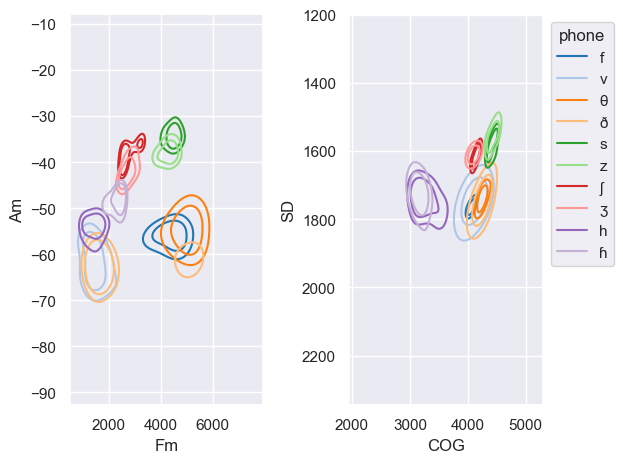

In [44]:
fig1, axs = plt.subplots(ncols=2)

fric_hue_order = ['f','v','θ','ð','s','z','ʃ','ʒ','h','ɦ']

sns.axes_style("darkgrid")
sns.set_theme()

sns.kdeplot(data=phones_data[phones_data['gender'].isin(["m"])],x="Fm", y="Am", 
            levels=[0.8,0.9],hue="phone",hue_order = fric_hue_order, 
            palette= sns.color_palette("tab20"),common_norm=False,cut=0,ax=axs[0],
            legend=False)
#axs[0].set_xlim(left=1500,right=7000)

sns.kdeplot(data=phones_data[phones_data['gender'].isin(["m"])],x="COG", y="SD", 
            levels=[0.8,0.9], hue="phone",hue_order = fric_hue_order, 
            palette= sns.color_palette("tab20"),common_norm=False,cut=0,ax=axs[1])
axs[1].invert_yaxis() 

sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
fig1.tight_layout()

In [45]:
fig1.savefig("timit_spaces.png", dpi=300.0, pad_inches=0.1)

In [46]:
pd.crosstab(phones_data["mode"],phones_data["phone"])

phone,f,h,s,v,z,ð,ɦ,ʃ,ʒ,θ
mode,,,,,,,,,,
1. 500/80%/6dB,2560,1040,9242,1668,4620,1200,1342,3021,217,773
2. 500/70%/6dB,50,0,36,145,19,64,10,0,0,22
3. 500/65%/4dB,399,4,581,270,216,116,10,0,0,118
5. 500/33%/3dB,12,1,147,141,51,46,3,0,0,12
6. give up,0,0,9,2,2,0,0,0,0,0


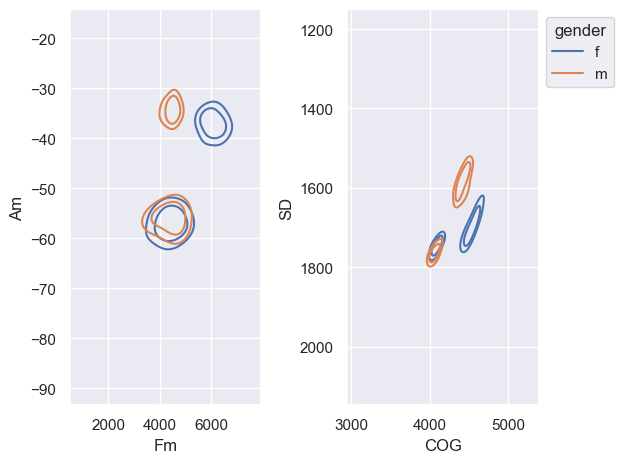

In [47]:
fig2, axs = plt.subplots(ncols=2)

sns.kdeplot(data=phones_data[phones_data["phone"].isin(["s"])],x="Fm", y="Am", 
            levels=[0.8,0.9],hue="gender",common_norm=False,cut=0,ax=axs[0],legend=False)
sns.kdeplot(data=phones_data[phones_data["phone"].isin(["f"])],x="Fm", y="Am", 
            levels=[0.8,0.9],hue="gender",common_norm=False,cut=0,ax=axs[0],legend=False)

sns.kdeplot(data=phones_data[phones_data["phone"].isin(["s"])],x="COG", y="SD", 
            levels=[0.8,0.9],hue="gender",common_norm=False,cut=0,ax=axs[1])
sns.kdeplot(data=phones_data[phones_data["phone"].isin(["f"])],x="COG", y="SD", 
            levels=[0.8,0.9],hue="gender",common_norm=False,cut=0,ax=axs[1])

axs[1].invert_yaxis()
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
fig2.tight_layout()
fig2.savefig("timit_gender_diff.png", dpi=300.0, pad_inches=0.1)

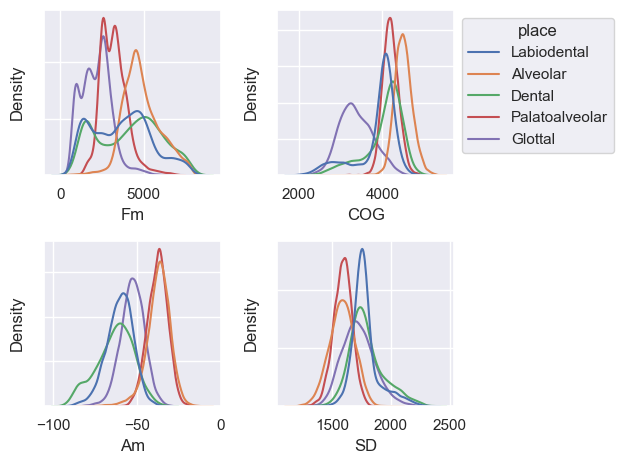

In [48]:
place_hue_order = ['Labiodental','Alveolar','Dental','Palatoalveolar','Glottal']

fig, axs = plt.subplots(nrows=2,ncols=2)
sns.kdeplot(data=phones_data,x="Fm",hue="place",hue_order = place_hue_order,
            common_norm=False,ax=axs[0][0], legend=False)
sns.kdeplot(data=phones_data,x="Am",hue="place",hue_order = place_hue_order,
            common_norm=False,ax=axs[1][0],legend=False)
sns.kdeplot(data=phones_data,x="COG",hue="place",hue_order = place_hue_order,
            common_norm=False,ax=axs[0][1])
sns.kdeplot(data=phones_data,x="SD",hue="place",hue_order = place_hue_order,
            common_norm=False,ax=axs[1][1],legend=False)
axs[0][0].yaxis.set_ticklabels([])
axs[1][0].yaxis.set_ticklabels([])
axs[0][1].yaxis.set_ticklabels([])
axs[1][1].yaxis.set_ticklabels([])

sns.move_legend(axs[0][1], "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

def warn(*args, **kwargs):   # this is a hack to avoid getting so many printed warning messages
    pass
import warnings
warnings.warn = warn

# select a test set randomly - no priors, each phone is equally likely
test_data = phones_data.groupby('phone').sample(900, random_state=42,replace=True)

LDA_n = 1

X1 = test_data[['Fm']].to_numpy()
LDA_model1 = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto",n_components=LDA_n)
scores = cross_val_score(LDA_model1, X1, test_data.place, cv=5)  # 5 fold cross-validation
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

X2 = test_data[['COG']].to_numpy()
LDA_model2 = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto",n_components=LDA_n)
scores = cross_val_score(LDA_model2, X2, test_data.place, cv=5)  # 5 fold cross-validation
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.38 accuracy with a standard deviation of 0.01
0.44 accuracy with a standard deviation of 0.02


/var/folders/dm/w8b4_nr15_ld7x64rrhjgcxh0000gn/T/ipykernel_49501/3829785825.py:3: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  sns.kdeplot(data=phones_data[phones_data["gender"].isin(["m"])],x="COG", y="SD",
/var/folders/dm/w8b4_nr15_ld7x64rrhjgcxh0000gn/T/ipykernel_49501/3829785825.py:9: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  sns.kdeplot(data=phones_data[phones_data["gender"].isin(["m"])],x="Skew", y="Kurtosis",


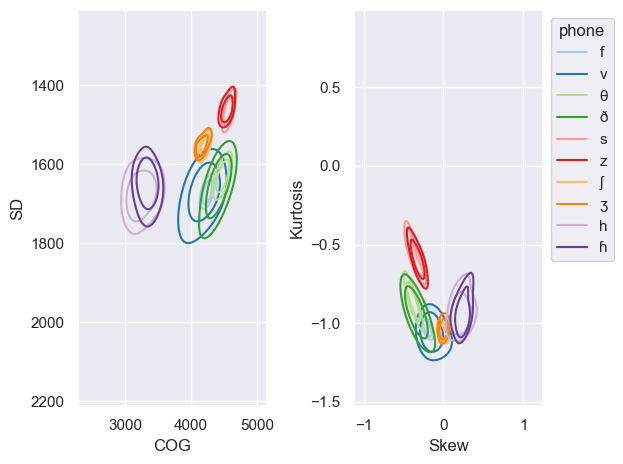

In [41]:
fig, axs = plt.subplots(ncols=2)

sns.kdeplot(data=phones_data[phones_data["gender"].isin(["m"])],x="COG", y="SD", 
            levels=[0.8,0.9],hue="phone",hue_order = fric_hue_order, 
            palette= sns.color_palette("Paired"),common_norm=False,cut=0,ax=axs[0],
            legend=False)
axs[0].invert_yaxis()

sns.kdeplot(data=phones_data[phones_data["gender"].isin(["m"])],x="Skew", y="Kurtosis", 
            levels=[0.8,0.9], hue="phone",hue_order = fric_hue_order, 
            palette= sns.color_palette("Paired"),common_norm=False,cut=0,ax=axs[1])

sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

<Axes: xlabel='FmB', ylabel='Density'>

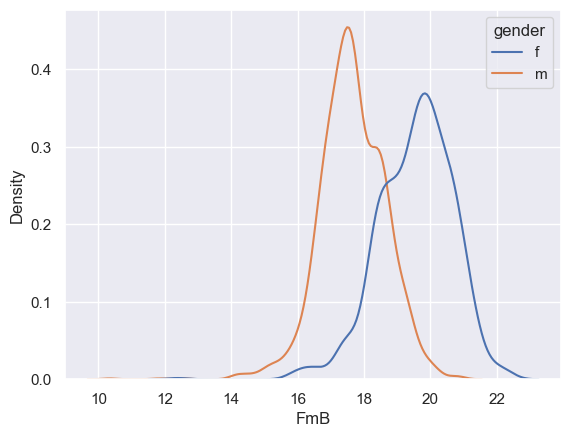

In [42]:
sns.kdeplot(data=phones_data[phones_data["phone"].isin(["s"])],
            x="FmB",hue="gender", common_norm=False)


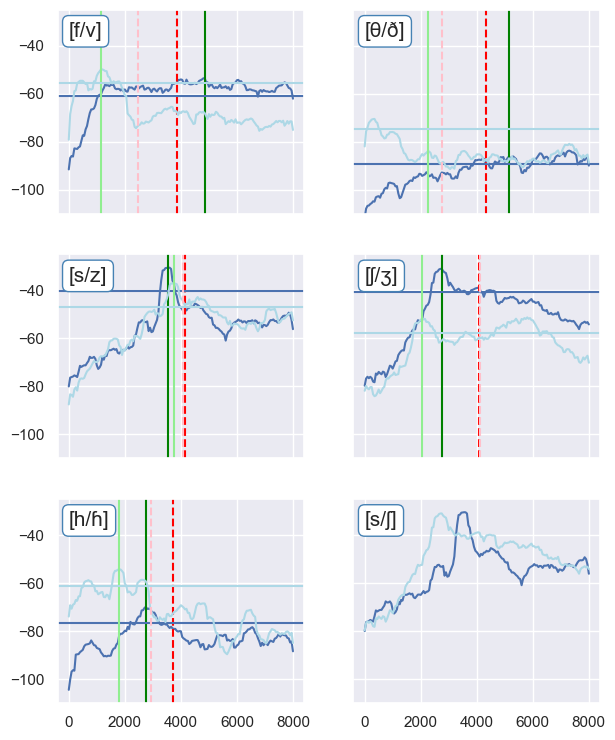

In [50]:
fig3, axs = plt.subplots(ncols=2,nrows=3, figsize=(7, 9))

axs[0][0].plot(freq,f_spec)
axs[0][0].axvline(f_Fm,color='green')
axs[0][0].axvline(f_COG, color='red',linestyle='dashed')
axs[0][0].axhline(np.min(f_spec) + (np.max(f_spec)-np.min(f_spec))*0.8)

axs[0][0].plot(freq,v_spec,color='lightblue')
axs[0][0].axvline(v_Fm,color='lightgreen')
axs[0][0].axvline(v_COG, color='pink',linestyle='dashed')
axs[0][0].axhline(np.min(v_spec) + (np.max(v_spec)-np.min(v_spec))*0.8,color='lightblue')
axs[0][0].text(0, -30, "[f/v]", ha="left", va="top", size=15,
            bbox=dict(boxstyle="round",fc="white", ec="steelblue", lw=1))

# -----------------
axs[0][1].plot(freq,th_spec)
axs[0][1].axvline(th_Fm,color='green')
axs[0][1].axvline(th_COG, color='red',linestyle='dashed')
axs[0][1].axhline(np.min(th_spec) + (np.max(th_spec)-np.min(th_spec))*0.8)

axs[0][1].plot(freq,dh_spec,color='lightblue')
axs[0][1].axvline(dh_Fm,color='lightgreen')
axs[0][1].axvline(dh_COG, color='pink',linestyle='dashed')
axs[0][1].axhline(np.min(dh_spec) + (np.max(dh_spec)-np.min(dh_spec))*0.8,color='lightblue')
axs[0][1].text(0, -30, "[θ/ð]", ha="left", va="top", size=15,
            bbox=dict(boxstyle="round",fc="white", ec="steelblue", lw=1))

# -----------------
axs[1][0].plot(freq,s_spec)
axs[1][0].axvline(s_Fm,color='green')
axs[1][0].axvline(s_COG, color='red',linestyle='dashed')
axs[1][0].axhline(np.min(s_spec) + (np.max(s_spec)-np.min(s_spec))*0.8)

axs[1][0].plot(freq,z_spec,color='lightblue')
axs[1][0].axvline(z_Fm,color='lightgreen')
axs[1][0].axvline(z_COG, color='pink',linestyle='dashed')
axs[1][0].axhline(np.min(z_spec) + (np.max(z_spec)-np.min(z_spec))*0.8,color='lightblue')
axs[1][0].text(0, -30, "[s/z]", ha="left", va="top", size=15,
            bbox=dict(boxstyle="round",fc="white", ec="steelblue", lw=1))

# -----------------
axs[1][1].plot(freq,sh_spec)
axs[1][1].axvline(sh_Fm,color='green')
axs[1][1].axvline(sh_COG, color='red',linestyle='dashed')
axs[1][1].axhline(np.min(sh_spec) + (np.max(sh_spec)-np.min(sh_spec))*0.8)

axs[1][1].plot(freq,zh_spec,color='lightblue')
axs[1][1].axvline(zh_Fm,color='lightgreen')
axs[1][1].axvline(zh_COG, color='pink',linestyle='dashed')
axs[1][1].axhline(np.min(zh_spec) + (np.max(zh_spec)-np.min(zh_spec))*0.8,color='lightblue')
axs[1][1].text(0, -30, "[ʃ/ʒ]", ha="left", va="top", size=15,
            bbox=dict(boxstyle="round",fc="white", ec="steelblue", lw=1))

# -----------------
axs[2][0].plot(freq,hh_spec)
axs[2][0].axvline(hh_Fm,color='green')
axs[2][0].axvline(hh_COG, color='red',linestyle='dashed')
axs[2][0].axhline(np.min(hh_spec) + (np.max(hh_spec)-np.min(hh_spec))*0.8)

axs[2][0].plot(freq,hv_spec,color='lightblue')
axs[2][0].axvline(hv_Fm,color='lightgreen')
axs[2][0].axvline(hv_COG, color='pink',linestyle='dashed')
axs[2][0].axhline(np.min(hv_spec) + (np.max(hv_spec)-np.min(hv_spec))*0.8,color='lightblue')
axs[2][0].text(0, -30, "[h/ɦ]", ha="left", va="top", size=15,
            bbox=dict(boxstyle="round",fc="white", ec="steelblue", lw=1))

axs[2][1].plot(freq,s_spec)
axs[2][1].plot(freq,sh_spec,color='lightblue')
axs[2][1].text(0, -30, "[s/ʃ]", ha="left", va="top", size=15,
            bbox=dict(boxstyle="round",fc="white", ec="steelblue", lw=1))

               
axs[0][0].set_ylim(bottom=-110,top=-25)
axs[0][1].set_ylim(bottom=-110,top=-25)
axs[1][0].set_ylim(bottom=-110,top=-25)
axs[1][1].set_ylim(bottom=-110,top=-25)
axs[2][0].set_ylim(bottom=-110,top=-25)
axs[2][1].set_ylim(bottom=-110,top=-25)

axs[0][0].xaxis.set_ticklabels([])
axs[0][1].yaxis.set_ticklabels([])
axs[0][1].xaxis.set_ticklabels([])
axs[1][0].xaxis.set_ticklabels([])
axs[1][1].xaxis.set_ticklabels([])
axs[1][1].yaxis.set_ticklabels([])
axs[2][1].yaxis.set_ticklabels([])

fig3.savefig('timit_spectra.png',dpi=300.0)